In [144]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Alignment amplitude detection

This notebook contains the pipeline needed to compute the projected tidal tensor and compare it with the directions of galaxy shapes. Some of the key routines are packed into a module `tidal.py`.

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
import tidal
np.seterr(divide='ignore',invalid='ignore');

## Data preprocessing
First read the data and set up some basic cuts (depth, size and ellipticity).

In [146]:
nside=64
cat=fits.open("data/2MASS_XSC.fits")[1].data
kmask=cat['kcorr_schlegel']<13.6
jmask=cat['j_m_k20fe'] > -12345
rmask=np.log10(cat['r_3sig'])>0.6
emask=cat['j_ba']<=0.8
jkmask=cat['j_m_k20fe']-cat['k_m_k20fe']>1.2

Apply cuts to generate tidal sample and alignment sample

In [147]:
cat_tidal=cat[kmask];
cat_align=cat[kmask*jmask*rmask*emask*jkmask]

Get spherical coordinates and mask

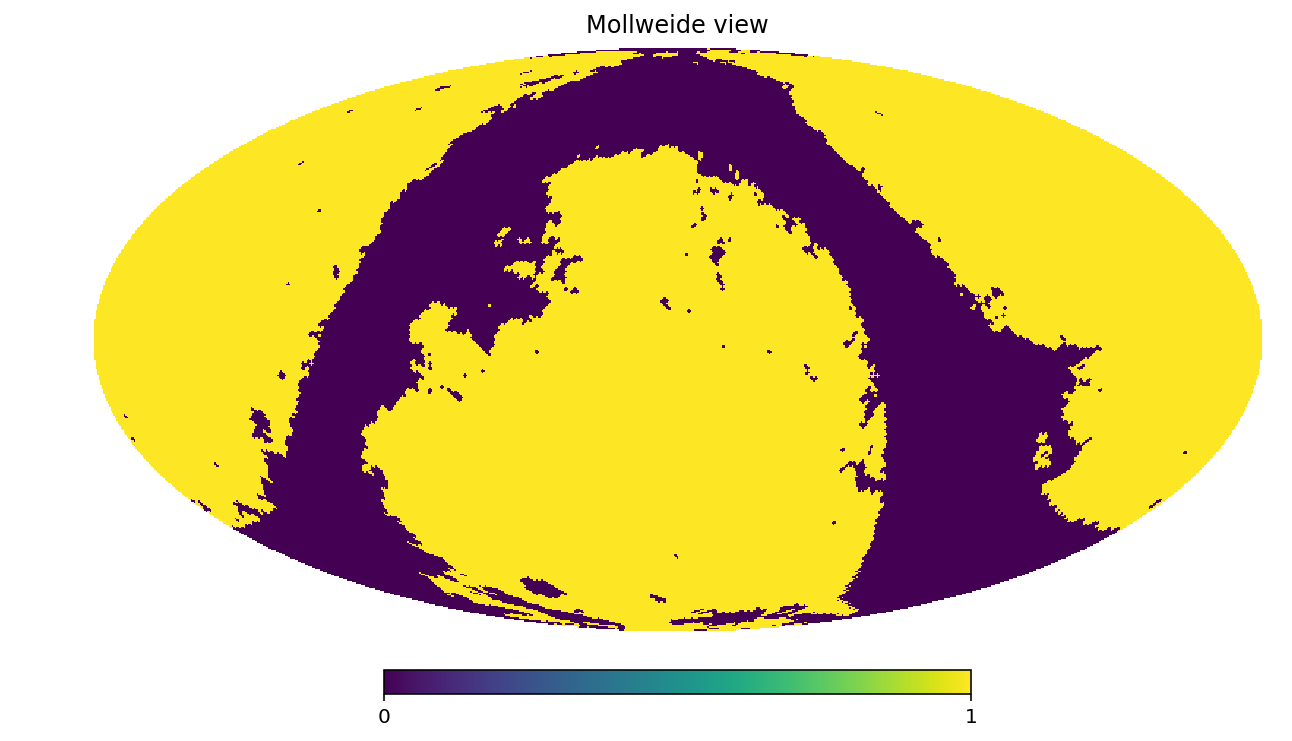

In [148]:
theta_tidal,phi_tidal=tidal.get_theta_phi(cat_tidal['sup_dec'],cat_tidal['sup_ra'],coords='EQ',rotate=False)
theta_align,phi_align=tidal.get_theta_phi(cat_align['sup_dec'],cat_align['sup_ra'],coords='EQ',rotate=False)
ipix_tidal=hp.ang2pix(nside,theta_tidal,phi_tidal)
ipix_align=hp.ang2pix(nside,theta_align,phi_align)
mask=tidal.get_mask(theta_tidal,phi_tidal,nside=nside,coords='EQ',rotate=False)
hp.mollview(mask)

Get tidal map

Making delta map
Computing power spectra
Generating constrained realization
Solving
Computing tidal field


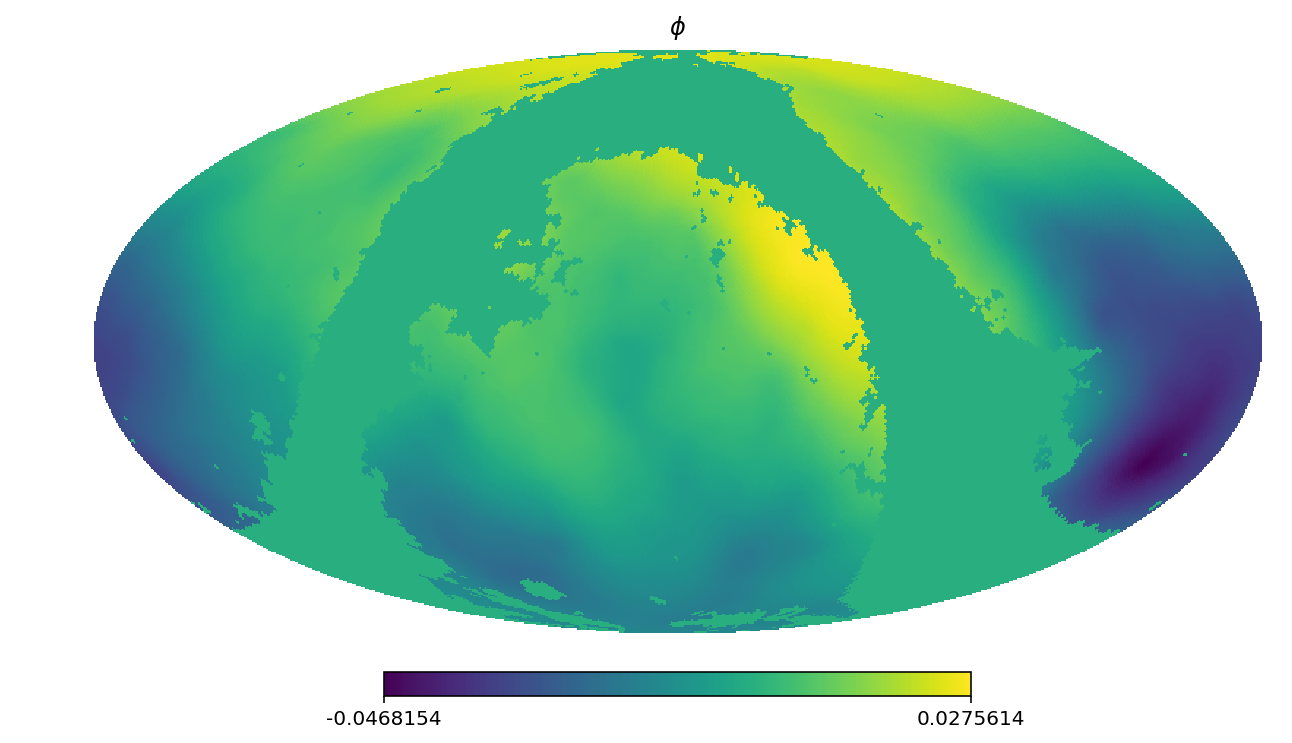

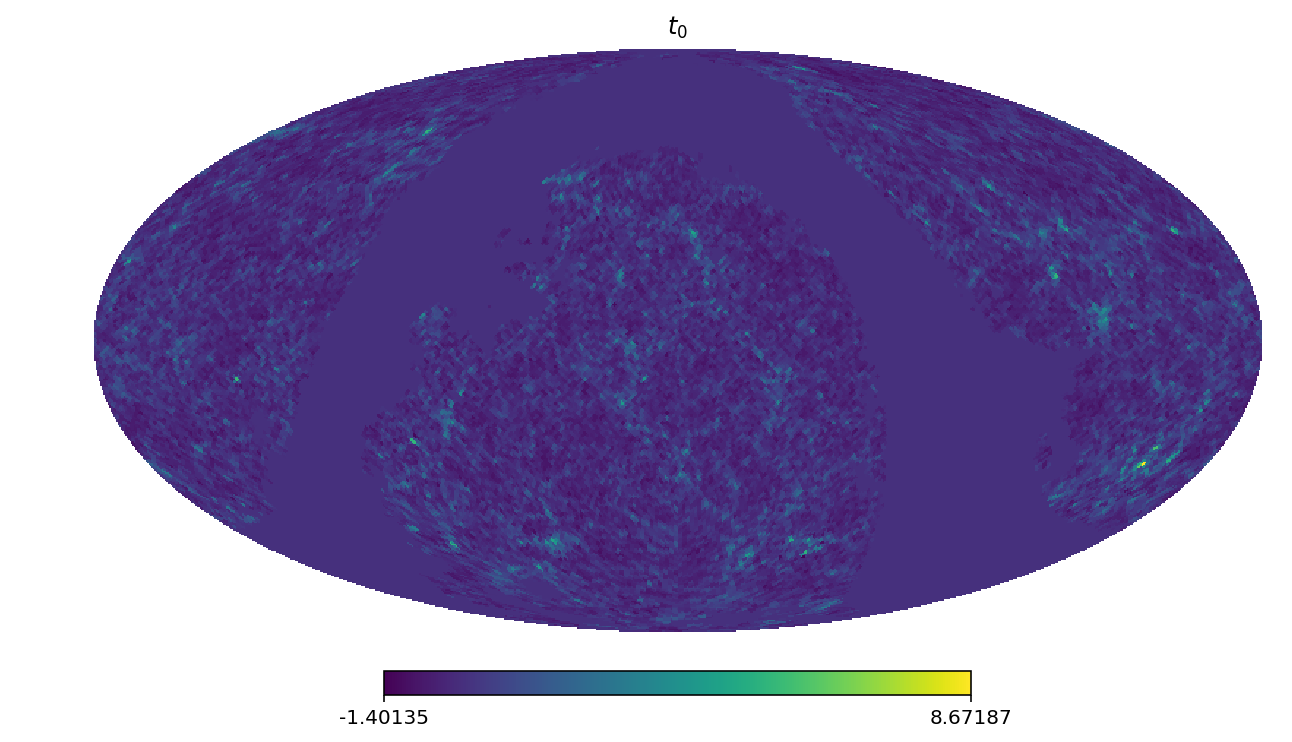

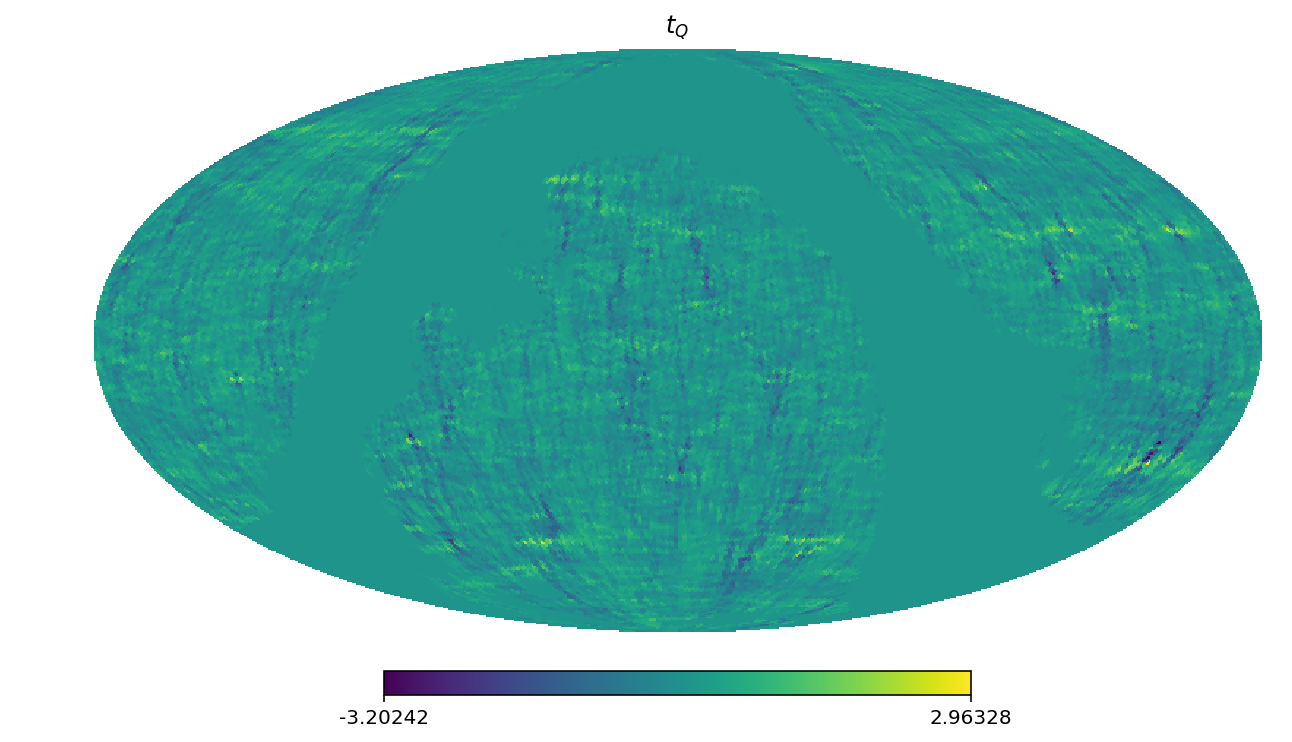

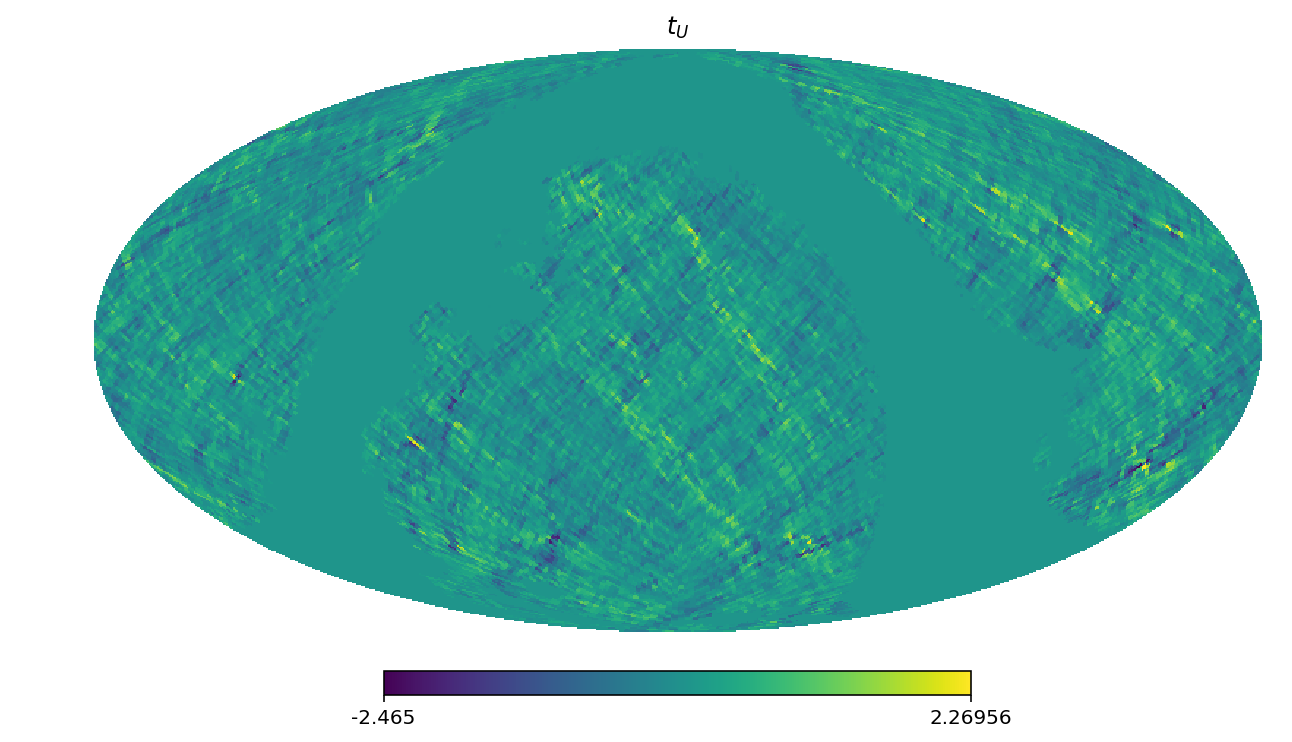

In [149]:
delta0,delta,pot,t11,t21,t22=tidal.get_tidal_maps(theta_tidal,phi_tidal,mask,theta_sm=0.0,
                                                  verbose=True,return_density_and_potential=True)
t_0=delta; t_Q=t11-t22; t_U=2*t21;
hp.mollview(pot*mask,title='$\\phi$')
hp.mollview(t_0*mask,title='$t_0$')
hp.mollview(t_Q*mask,title='$t_Q$')
hp.mollview(t_U*mask,title='$t_U$')

Angular mask

In [150]:
msk_ang=mask[ipix_align]>0
n_unmasked=np.sum(msk_ang)

Convenience function to generate inertia tensor from shape information.

In [151]:
def get_inertia_tensor(phi,s,r):
    c2a,s2a=np.cos(2*phi),-np.sin(2*phi)
    i_0h=0.25*r**2*(1+s**2)
    i_Qh=i_0h*(1-s**2)*c2a/(1+s**2)
    i_Uh=i_0h*(1-s**2)*s2a/(1+s**2)
    return i_0h,i_Qh,i_Uh

Get shape components

In [152]:
i_0g,i_Qg,i_Ug=get_inertia_tensor(cat_align['j_phi'][msk_ang],
                                  cat_align['j_ba'][msk_ang],
                                  cat_align['r_3sig'][msk_ang])

Get tidal field at galaxy positions

In [153]:
t_0g=t_0[ipix_align][msk_ang]
t_Qg=t_Q[ipix_align][msk_ang]
t_Ug=t_U[ipix_align][msk_ang]

Convenience function to generate arbitrary shape maps

In [154]:
def get_random_shapes(method='rotate'):
    if method=='rotate':
        r=cat_align['r_3sig'][msk_ang]
        s=cat_align['j_ba'][msk_ang]
        phi=cat_align['j_phi'][msk_ang]+2*np.pi*np.random.rand(n_unmasked)
    else:
        r,s,phi=np.random.permutation(np.array((cat_align['r_3sig'][msk_ang],
                                                cat_align['j_ba'][msk_ang],
                                                cat_align['j_phi'][msk_ang])).T).T
    return get_inertia_tensor(phi,s,r)

## Zero-lag estimators

In [155]:
def get_A_zerolag(i0,iQ,iU,quantity='ellipticity'):
    msk_ang=mask[ipix_align]>0
    if quantity=='ellipticity': #Use ellipticities
        e0=np.zeros_like(i0)
        eQ=(iQ/i0); eU=(iU/i0);
    else: #Use normalized inertia
        i0_mean=np.mean(i0)
        e0=i0/i0_mean-1
        eQ=iQ/i0_mean
        eU=iU/i0_mean
    x0=np.sum(e0*t_0g)/np.sum(t_0g)
    x2=np.sum(eQ*t_Qg+eU*t_Ug)/np.sum(t_Qg**2+t_Ug**2)
    return x0,x2

Estimate alignment amplitude from the data

In [156]:
a0,a2=get_A_zerolag(i_0g,i_Qg,i_Ug,quantity='norminertia')
_,b2=get_A_zerolag(i_0g,i_Qg,i_Ug,quantity='ellipticity')

Estimate from mocks

In [157]:
nsims=1000
a0s_r=np.zeros(nsims); a2s_r=np.zeros(nsims); b2s_r=np.zeros(nsims);
a0s_s=np.zeros(nsims); a2s_s=np.zeros(nsims); b2s_s=np.zeros(nsims);
for i in range(nsims):
    if i%100==0:
        print(i)
    #Rotate stuff
    i0,iQ,iU=get_random_shapes('rotate')
    a0s_r[i],a2s_r[i]=get_A_zerolag(i0,iQ,iU,quantity='norminertia')
    _,b2s_r[i]=get_A_zerolag(i0,iQ,iU,quantity='ellipticity')
    #Shuffle stuff
    i0,iQ,iU=get_random_shapes('shuffle')
    a0s_s[i],a2s_s[i]=get_A_zerolag(i0,iQ,iU,quantity='norminertia')
    _,b2s_s[i]=get_A_zerolag(i0,iQ,iU,quantity='ellipticity')


0
100
200
300
400
500
600
700
800
900


Plot results

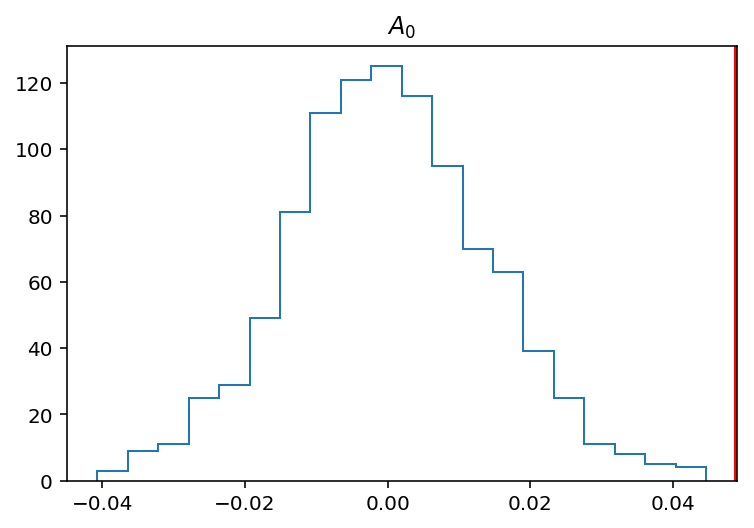

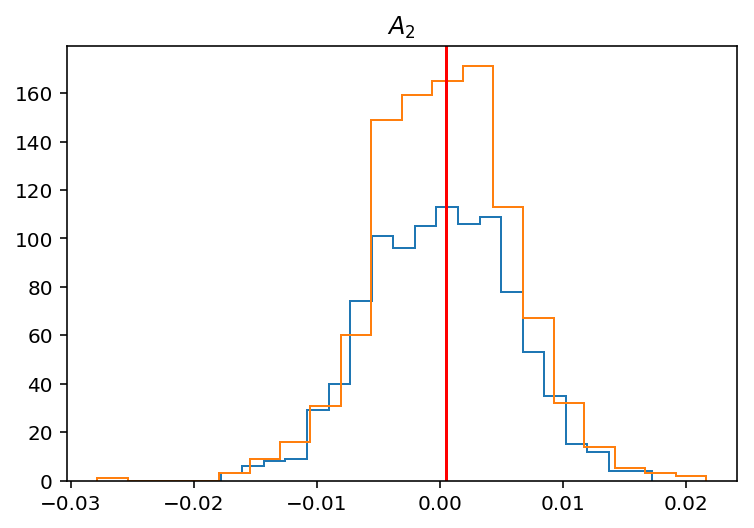

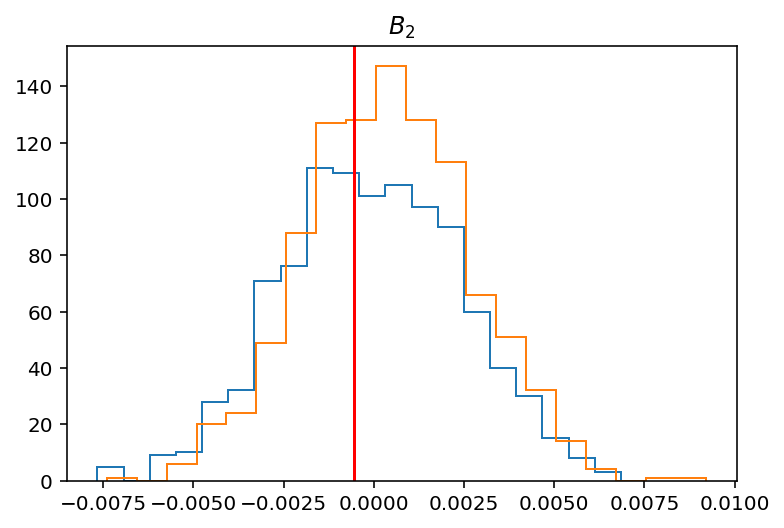

In [158]:
plt.figure(); plt.title("$A_0$")
plt.hist(a0s_s,histtype='step',bins=20)
plt.axvline(a0, color="red", label="data")

plt.figure(); plt.title("$A_2$")
plt.hist(a2s_r,histtype='step',bins=20)
plt.hist(a2s_s,histtype='step',bins=20)
plt.axvline(a2, color="red", label="data")

plt.figure(); plt.title("$B_2$")
plt.hist(b2s_r,histtype='step',bins=20)
plt.hist(b2s_s,histtype='step',bins=20)
plt.axvline(b2, color="red", label="data")


## Cross-correlation estimator

Start by estimating the density field power spectrum

In [115]:
fsky=np.mean(mask)
larr=np.arange(3*nside)
cltt=hp.anafast(delta0)/fsky #Data power spectrum
nltt=4*np.pi*fsky*np.ones(3*nside)/np.sum(mask[ipix_tidal]>0) #Noise

#Fit smooth function
logls=np.log(larr[1:]); logcls=np.log(cltt[1:])
err=np.sqrt(2./(2*larr[1:]+1))
poly=np.poly1d(np.polyfit(logls,logcls,5,w=1/err))
ls_fit=larr.copy(); ls_fit[0]=1; cls_fit=np.exp(poly(np.log(ls_fit)))
sltt=cls_fit-nltt #Signal power spectrum

Convenience function to compute power spectra

(129577, 74596)


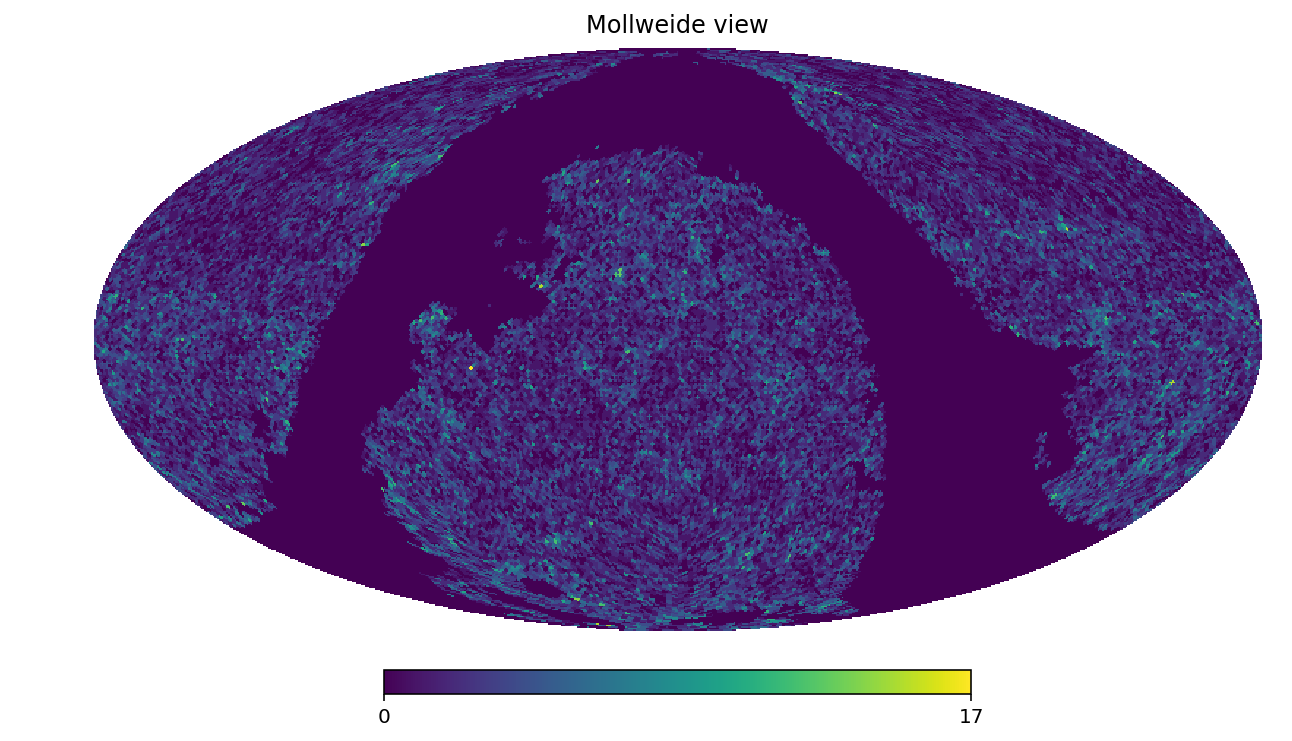

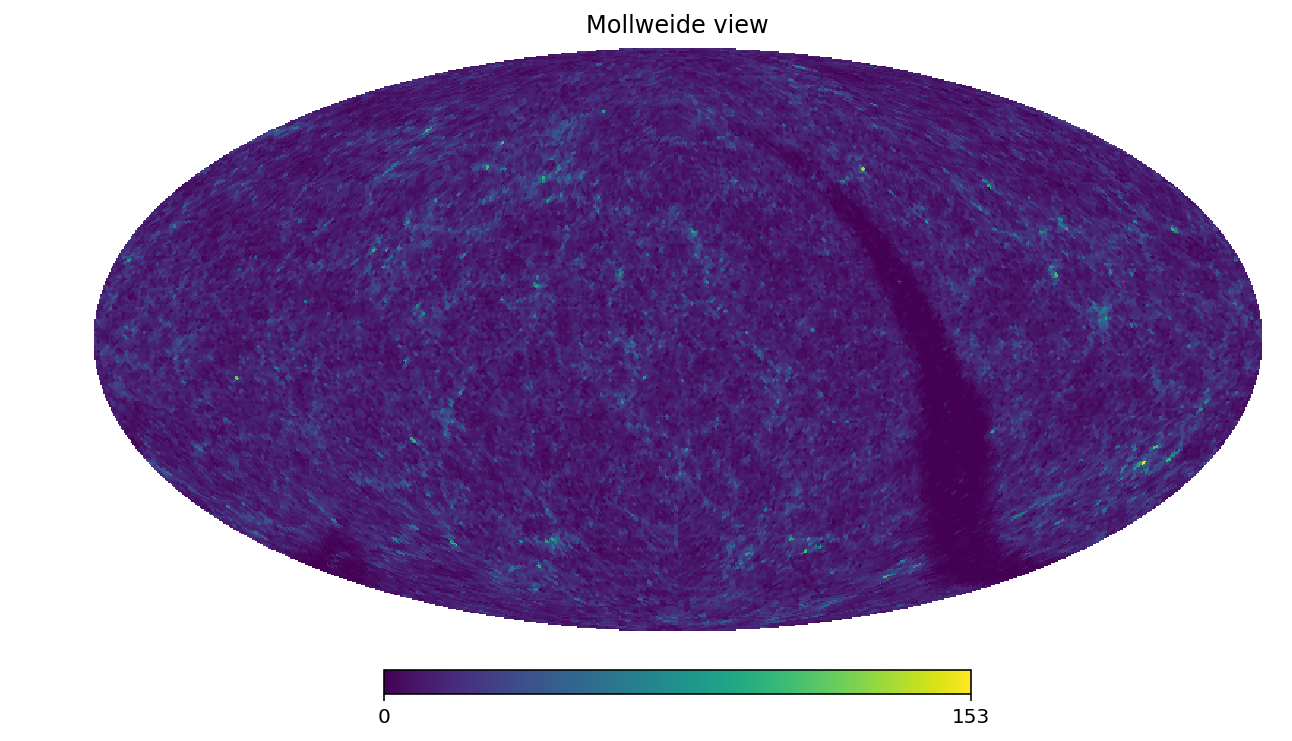

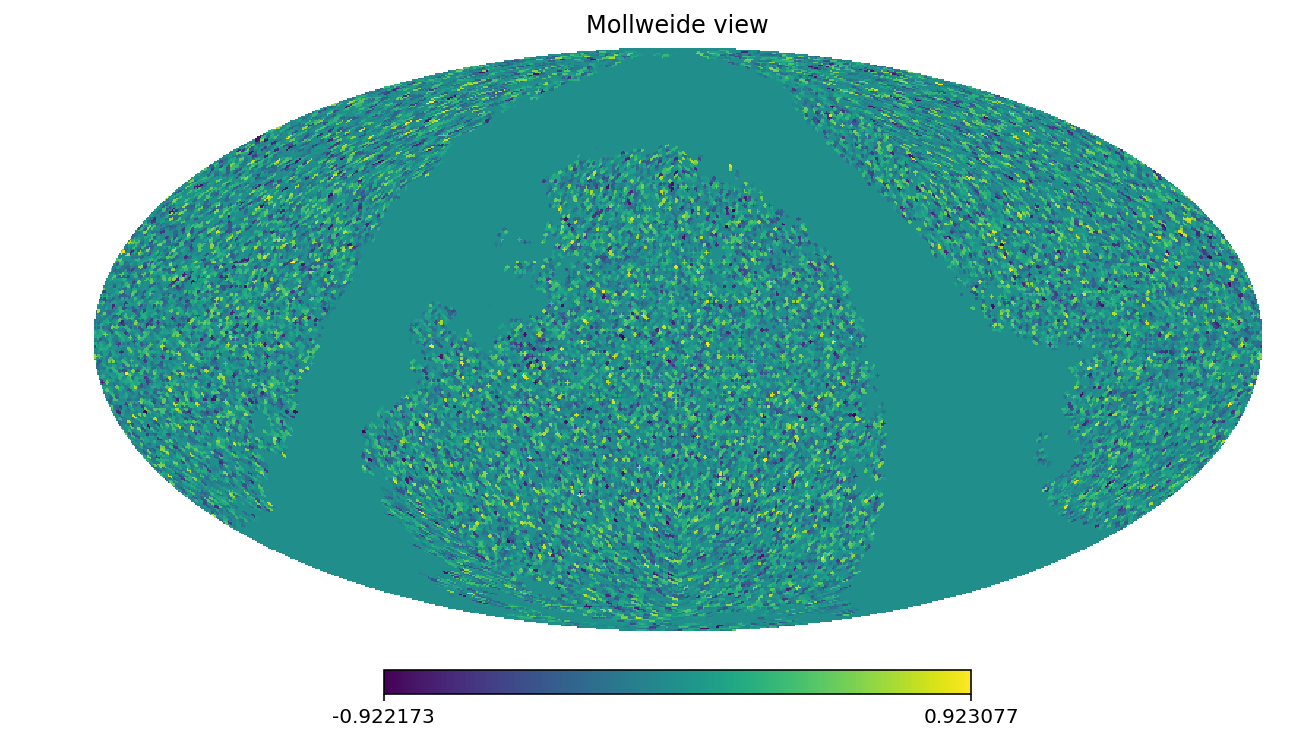

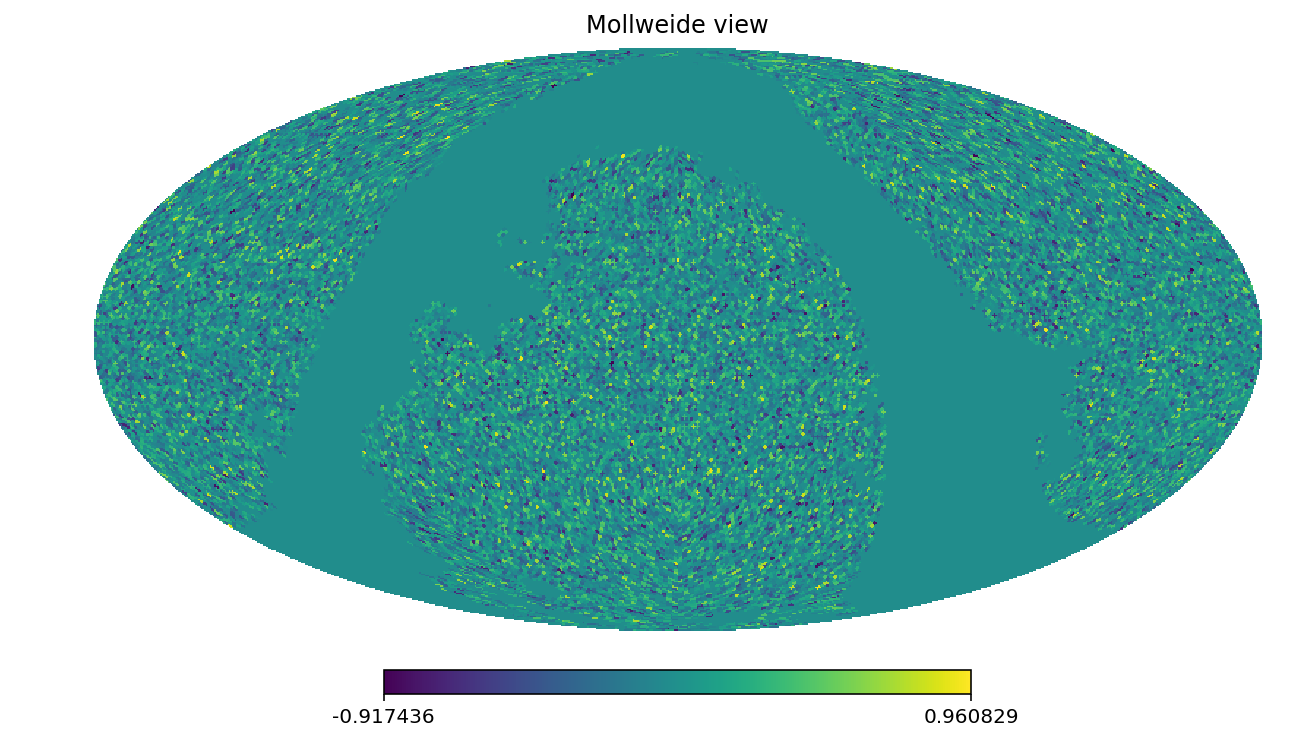

In [116]:
#Ngal map
ngal_map=np.bincount(ipix_align,minlength=hp.nside2npix(nside))

def get_shape_maps(i0,iQ,iU,quantity='ellipticity'):
    if quantity=='ellipticity':
        e0=np.zeros_like(i0)
        eQ=(iQ/i0); eU=(iU/i0);
    else: #Use normalized inertia
        i0_mean=np.mean(i0)
        e0=i0/i0_mean-1
        eQ=iQ/i0_mean
        eU=iU/i0_mean
q_map=np.bincount(ipix_align[msk_ang],minlength=hp.nside2npix(nside),weights=i_Qg/i_0g)
 
print(len(ipix_align),len(i_Qg))
q_map=np.bincount(ipix_align[msk_ang],minlength=hp.nside2npix(nside),weights=i_Qg/i_0g)
u_map=np.bincount(ipix_align[msk_ang],minlength=hp.nside2npix(nside),weights=i_Ug/i_0g)
q_map[ngal_map>0]/=ngal_map[ngal_map>0]
u_map[ngal_map>0]/=ngal_map[ngal_map>0]
hp.mollview(ngal_map*mask)
hp.mollview(np.bincount(ipix_tidal,minlength=hp.nside2npix(nside)))
hp.mollview(q_map)
hp.mollview(u_map)